In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
np.random.seed(42)

In [6]:
def load_data(filepath):
    """Load data from CSV file."""
    print(f"Loading data from {filepath}...")
    try:
        # Read data
        df = pd.read_csv(filepath)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [7]:
def preprocess_data(df, input_features, output_features):
    """
    Preprocess the data for modeling.
    
    Args:
        df: DataFrame containing the vehicle data
        input_features: List of feature columns to use for prediction
        output_features: List of target columns to predict
    
    Returns:
        X_train, X_test, y_train, y_test, preprocessor
    """
    print("\nPreprocessing data...")
    
    # Select relevant columns
    data = df[input_features + output_features].copy()
    
    # Check for missing values
    missing = data.isnull().sum()
    print(f"\nMissing values per column:\n{missing[missing > 0]}")
    
    # Drop rows with missing values (alternatively, you could impute them)
    data_clean = data.dropna()
    print(f"Shape after dropping missing values: {data_clean.shape}")
    
    # Separate features and targets
    X = data_clean[input_features]
    y = data_clean[output_features]
    
    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    print(f"\nCategorical features: {categorical_features}")
    print(f"Numerical features: {numerical_features}")
    
    # Create preprocessor for feature transformation
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"\nTraining set size: {X_train.shape[0]}")
    print(f"Testing set size: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test, preprocessor, categorical_features, numerical_features


In [8]:
def build_and_train_model(X_train, y_train, preprocessor):
    """
    Build and train a machine learning pipeline with preprocessing and model.
    
    Args:
        X_train: Training features
        y_train: Training targets
        preprocessor: Column transformer for preprocessing
    
    Returns:
        Trained model pipeline
    """
    print("\nBuilding and training model...")
    
    # Create Random Forest Regressor for multiple outputs
    model = MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    print("Training model... (this may take a few minutes)")
    pipeline.fit(X_train, y_train)
    print("Model training completed.")
    
    return pipeline

In [9]:
def evaluate_model(model, X_test, y_test, output_features):
    """
    Evaluate the model performance on test data.
    
    Args:
        model: Trained model pipeline
        X_test: Test features
        y_test: Test targets
        output_features: Names of target features
    
    Returns:
        Dictionary of evaluation metrics
    """
    print("\nEvaluating model...")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Convert to DataFrame if y_pred is a numpy array
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.DataFrame(y_pred, columns=output_features)
    
    # Calculate metrics for each output
    metrics = {}
    for i, col in enumerate(output_features):
        rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
        r2 = r2_score(y_test[col], y_pred[col])
        
        print(f"\nMetrics for {col}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²: {r2:.4f}")
        
        metrics[col] = {
            'rmse': rmse,
            'r2': r2
        }
    
    # Visualize predictions vs actual
    fig, axes = plt.subplots(1, len(output_features), figsize=(15, 5))
    if len(output_features) == 1:
        axes = [axes]
    
    for i, col in enumerate(output_features):
        axes[i].scatter(y_test[col], y_pred[col], alpha=0.3)
        axes[i].plot([y_test[col].min(), y_test[col].max()], 
                     [y_test[col].min(), y_test[col].max()], 
                     'k--', lw=2)
        axes[i].set_xlabel(f'Actual {col}')
        axes[i].set_ylabel(f'Predicted {col}')
        axes[i].set_title(f'{col} - R² = {metrics[col]["r2"]:.4f}')
    
    plt.tight_layout()
    plt.show()
    
    return metrics


In [10]:
def analyze_feature_importance(model, categorical_features, numerical_features, preprocessor):
    """
    Analyze and visualize feature importance.
    
    Args:
        model: Trained model pipeline
        categorical_features: List of categorical feature names
        numerical_features: List of numerical feature names
        preprocessor: Column transformer used for preprocessing
    """
    print("\nAnalyzing feature importance...")
    
    # Get feature names after one-hot encoding
    ohe = preprocessor.named_transformers_['cat']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names = np.concatenate([cat_feature_names, numerical_features])
    
    # Extract feature importances from the model
    # For MultiOutputRegressor, we need to access the base_estimator and average importances
    rf_models = model.named_steps['model'].estimators_
    all_importances = np.zeros(len(feature_names))
    
    for rf in rf_models:
        all_importances += rf.feature_importances_
    
    # Average importances across all estimators
    feature_importances = all_importances / len(rf_models)
    
    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    top_features = importance_df.head(20)
    print("\nTop 20 important features:")
    print(top_features)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df


In [11]:
def save_model(model, output_dir='model'):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained model pipeline
        output_dir: Directory to save the model
    """
    print(f"\nSaving model to {output_dir}/vehicle_consumption_emissions_model.joblib...")
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the model
    joblib.dump(model, f'{output_dir}/vehicle_consumption_emissions_model.joblib')
    print("Model saved successfully.")

Loading data from Fuel_Consumption_2000-2022.csv...
Data loaded successfully. Shape: (22556, 13)

Preprocessing data...

Missing values per column:
Series([], dtype: int64)
Shape after dropping missing values: (22556, 9)

Categorical features: ['MAKE', 'MODEL', 'VEHICLE CLASS', 'TRANSMISSION', 'FUEL']
Numerical features: ['ENGINE SIZE', 'CYLINDERS']

Training set size: 18044
Testing set size: 4512

Building and training model...
Training model... (this may take a few minutes)
Model training completed.

Evaluating model...

Metrics for COMB (L/100 km):
RMSE: 0.6042
R²: 0.9564

Metrics for EMISSIONS:
RMSE: 13.8401
R²: 0.9447


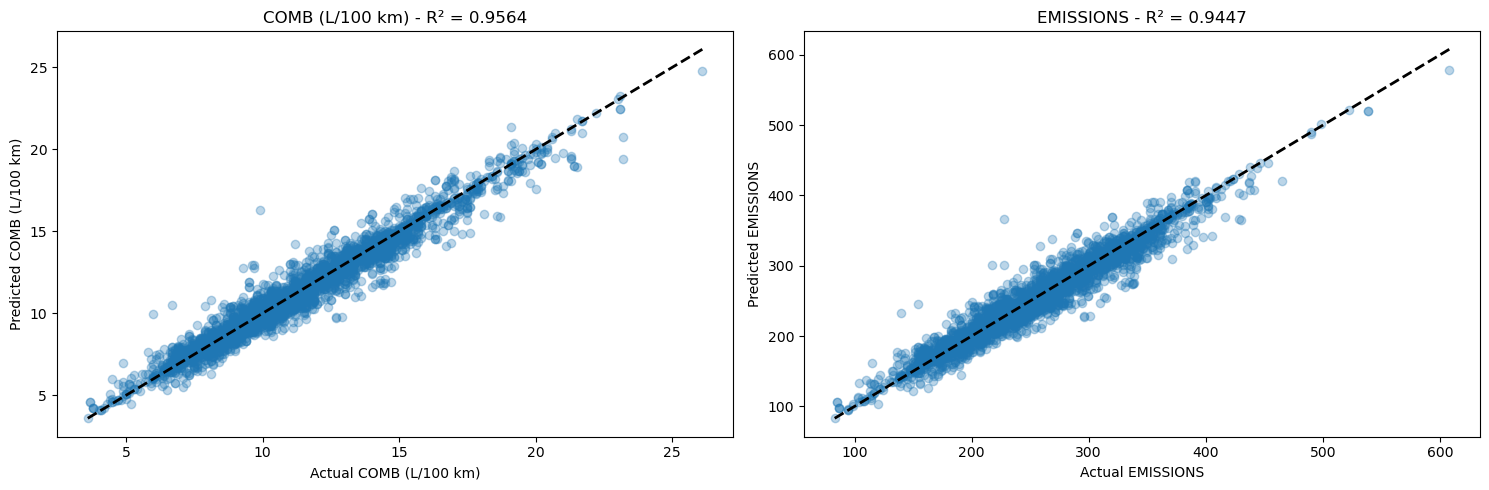


Analyzing feature importance...

Top 20 important features:
                                    Feature  Importance
4132                            ENGINE SIZE    0.694825
4128                                 FUEL_E    0.050878
4133                              CYLINDERS    0.034047
4117                        TRANSMISSION_AV    0.014342
4069                 VEHICLE CLASS_MID-SIZE    0.011768
4067                VEHICLE CLASS_FULL-SIZE    0.007807
24                             MAKE_FERRARI    0.006852
4131                                 FUEL_Z    0.005915
4095          VEHICLE CLASS_VAN - PASSENGER    0.005390
4065                  VEHICLE CLASS_COMPACT    0.004876
27                                MAKE_Ford    0.004491
4082               VEHICLE CLASS_SUBCOMPACT    0.004319
4086               VEHICLE CLASS_SUV: Small    0.003869
4076  VEHICLE CLASS_PICKUP TRUCK - STANDARD    0.003707
4087            VEHICLE CLASS_SUV: Standard    0.003636
4099                        TRANSMISSION_A4

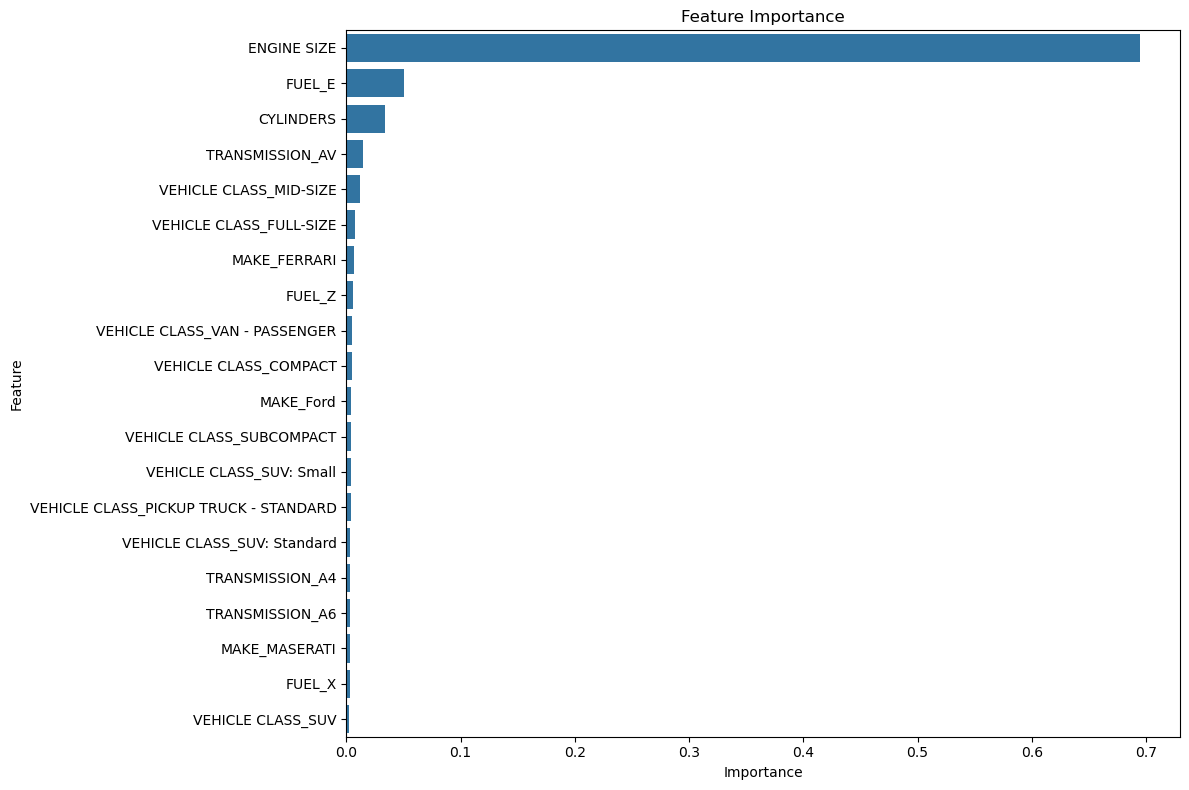


Saving model to model/vehicle_consumption_emissions_model.joblib...
Model saved successfully.

Example prediction:
Vehicle: {'MAKE': 'TOYOTA', 'MODEL': 'COROLLA', 'VEHICLE CLASS': 'COMPACT', 'ENGINE SIZE': 1.8, 'CYLINDERS': 4, 'TRANSMISSION': 'AS', 'FUEL': 'X'}
Predicted Fuel Consumption: 6.79 L/100km
Predicted Emissions: 157.51


In [13]:
def create_prediction_function(model, categorical_features, numerical_features):
    """
    Create a function that takes a dictionary of vehicle features and returns predictions.
    
    Args:
        model: Trained model pipeline
        categorical_features: List of categorical feature names
        numerical_features: List of numerical feature names
    
    Returns:
        Prediction function
    """
    def predict_consumption_emissions(vehicle_specs):
        """
        Predict fuel consumption and CO2 emissions for a vehicle.
        
        Args:
            vehicle_specs: Dictionary with vehicle specifications
                (Make, Model, Vehicle Class, Engine Size, Cylinders, Transmission, Fuel Type)
        
        Returns:
            Dictionary with predicted fuel consumption and CO2 emissions
        """
        # Convert the dictionary to a DataFrame
        input_df = pd.DataFrame([vehicle_specs])
        
        # Make predictions
        predictions = model.predict(input_df)
        
        # Return results
        return {
            'Fuel Consumption (COMB L/100km)': predictions[0][0],
            'Emissions': predictions[0][1]
        }
    
    return predict_consumption_emissions

# Main function to orchestrate the workflow
def main():
    """Main function to execute the workflow."""
    # Define file path
    file_path = 'Fuel_Consumption_2000-2022.csv'
    
    # Define input and output features based on actual CSV column names
    input_features = [
        'MAKE', 'MODEL', 'VEHICLE CLASS', 
        'ENGINE SIZE', 'CYLINDERS', 'TRANSMISSION', 'FUEL'
    ]
    
    output_features = ['COMB (L/100 km)', 'EMISSIONS']
    
    # Load data
    df = load_data(file_path)
    
    if df is not None:
        # Preprocess data
        X_train, X_test, y_train, y_test, preprocessor, categorical_features, numerical_features = preprocess_data(
            df, input_features, output_features)
        
        # Build and train model
        model = build_and_train_model(X_train, y_train, preprocessor)
        
        # Evaluate model
        metrics = evaluate_model(model, X_test, y_test, output_features)
        
        # Analyze feature importance
        importance_df = analyze_feature_importance(model, categorical_features, numerical_features, model.named_steps['preprocessor'])
        
        # Save model
        save_model(model)
        
        # Create prediction function
        predict_func = create_prediction_function(model, categorical_features, numerical_features)
        
        # Example prediction
        example_vehicle = {
            'MAKE': 'TOYOTA',
            'MODEL': 'COROLLA',
            'VEHICLE CLASS': 'COMPACT',
            'ENGINE SIZE': 1.8,
            'CYLINDERS': 4,
            'TRANSMISSION': 'AS',
            'FUEL': 'X'
        }
        
        print("\nExample prediction:")
        prediction = predict_func(example_vehicle)
        print(f"Vehicle: {example_vehicle}")
        print(f"Predicted Fuel Consumption: {prediction['Fuel Consumption (COMB L/100km)']:.2f} L/100km")
        print(f"Predicted Emissions: {prediction['Emissions']:.2f}")

if __name__ == "__main__":
    main()